# L1 Data Visualization Notebook

This Report comprises the entire Data Visualization of the L1 data (Level 1 Data) of the Hotel Recommendation System built. 

In [24]:
import boto3
import pandas as pd
import matplotlib.pyplot as plt
from wordcloud import WordCloud
from textblob import TextBlob
from io import StringIO
import plotly.graph_objects as go
import plotly.express as px
from plotly.subplots import make_subplots
from datetime import datetime, timedelta
import colorlover as cl

In [73]:
# Generate a custom color palette with 15 shades of blue
cp = cl.scales['9']['seq']['Blues']
color_palette = cl.interp(cp, 15)

## Loading the dataset

First we should download the L1 CSV file from the S3 bucket and load it into a Pandas DataFrame. 

In [74]:
# Set up boto3 client
s3_client = boto3.client('s3', region_name='us-west-2')

# Define bucket and object key
bucket_name = 'andorra-hotels-data-warehouse'
object_key = 'l1_data/text/l1_data_2024-07-21_16-33-02.csv'

# Get the object from S3
response = s3_client.get_object(Bucket=bucket_name, Key=object_key)

# Read the data into a DataFrame
df = pd.read_csv(StringIO(response['Body'].read().decode('utf-8')))

# Display the first few rows of the DataFrame as a pretty table
df_head = df.head()

fig_table = go.Figure(data=[go.Table(
    header=dict(values=list(df_head.columns),
                fill_color='paleturquoise',
                align='left'),
    cells=dict(values=[df_head[col] for col in df_head.columns],
               fill_color='lavender', 
               align='left'))
])

fig_table.update_layout(
    title_text='First Few Rows of the DataFrame',
    title_x=0.5,
    font=dict(
        family="Arial, sans-serif",
        size=12,
        color="#000000"
    )
)

# Show the table
fig_table.show()

## 1. Distribution of Ratings

### 1.1. Histogram of Ratings

Visualize the distribution of Hotel ratings

In [41]:
# Plot histogram of ratings with Plotly
hist_data = df['rating'].value_counts().sort_index()
fig_hist = go.Figure(data=[go.Bar(
        x=hist_data.index,
        y=hist_data.values,
        marker_color=color_palette[10]
    )])
fig_hist.update_layout(
    title_text='Distribution of Hotel Ratings',
    title_x=0.5,
    xaxis_title='Rating',
    yaxis_title='Frequency',
    plot_bgcolor='rgba(0,0,0,0)',
    paper_bgcolor='rgba(0,0,0,0)',
    font=dict(
        family="Arial, sans-serif",
        size=16,
        color="#000000"
    )
)

# Show the histogram
fig_hist.show()

# Create a table with the ratings and their frequencies
ratings_count = df['rating'].value_counts().reset_index()
ratings_count.columns = ['Rating', 'Number of Ratings']
ratings_count = ratings_count.sort_values('Rating')

fig_table = go.Figure(data=[go.Table(
    header=dict(values=list(ratings_count.columns),
                fill_color='paleturquoise',
                align='center'),
    cells=dict(values=[ratings_count.Rating, ratings_count['Number of Ratings']],
               fill_color='lavender',
               align='center'))
])

fig_table.update_layout(
    title_text='Ratings Distribution Table',
    title_x=0.5,
    font=dict(
        family="Arial, sans-serif",
        size=12,
        color="#000000"
    )
)

# Show the table
fig_table.show()

### 1.2. Average Rating per region

Bar chart showing the average rating of hotels in each region.

In [43]:
# Calculate average rating per region
avg_rating_per_region = df.groupby('region')['rating'].mean().sort_values()

# Plot average rating per region with Plotly
fig_avg_rating = go.Figure(data=[go.Bar(
    x=avg_rating_per_region.index,
    y=avg_rating_per_region.values,
    marker_color=color_palette[5:]
)])

fig_avg_rating.update_layout(
    title_text='Average Hotel Rating per Region',
    title_x=0.5,
    xaxis_title='Region',
    yaxis_title='Average Rating',
    plot_bgcolor='rgba(0,0,0,0)',
    paper_bgcolor='rgba(0,0,0,0)',
    font=dict(
        family="Arial, sans-serif",
        size=12,
        color="#000000"
    ),
    xaxis_tickangle=-45
)

# Show the average rating per region plot
fig_avg_rating.show()

# Create a table with the average ratings per region
avg_rating_df = avg_rating_per_region.reset_index()
avg_rating_df.columns = ['Region', 'Average Rating']

fig_table = go.Figure(data=[go.Table(
    header=dict(values=list(avg_rating_df.columns),
                fill_color='paleturquoise',
                align='left'),
    cells=dict(values=[avg_rating_df.Region, avg_rating_df['Average Rating']],
                fill_color='lavender',
                align='left'))
])

fig_table.update_layout(
    title_text='Average Ratings per Region',
    title_x=0.5,
    font=dict(
        family="Arial, sans-serif",
        size=12,
        color="#000000"
    )
)

# Show the table
fig_table.show()

## 2. Reviews Analysis

### 2.1. Number of Reviews per hotel

Bar chart showing the total number of reviews for each hotel.

In [45]:
# Create a table with the average number of ratings per region
avg_ratings_per_region = df.groupby('region')['user_ratings_total'].mean().reset_index()
avg_ratings_per_region.columns = ['Region', 'Average Number of Ratings']

fig_table = go.Figure(data=[go.Table(
    header=dict(values=list(avg_ratings_per_region.columns),
                fill_color='paleturquoise',
                align='left'),
    cells=dict(values=[avg_ratings_per_region.Region, avg_ratings_per_region['Average Number of Ratings']],
                fill_color='lavender',
                align='left'))
])

fig_table.update_layout(
    title_text='Average Number of Ratings per Region',
    title_x=0.5,
    font=dict(
        family="Arial, sans-serif",
        size=12,
        color="#000000"
    )
)

# Show the table
fig_table.show()

#  Get the list of regions
regions = df['region'].unique()

# Create subplots
fig = make_subplots(rows=4, cols=2, subplot_titles=regions, horizontal_spacing=0.1, vertical_spacing=0.1)

# Plot the number of reviews per hotel for each region using user_ratings_total
for i, region in enumerate(regions):
    region_df = df[df['region'] == region]
    reviews_per_hotel = region_df.groupby('hotel_name')['user_ratings_total'].sum().sort_values(ascending=False)
    
    row = i // 2 + 1
    col = i % 2 + 1
    
    fig.add_trace(
        go.Bar(
            x=reviews_per_hotel.index,
            y=reviews_per_hotel.values,
            marker_color=color_palette[10],
            name=region
        ),
        row=row, col=col
    )
    
    fig.update_xaxes(title_text='Hotel Name', row=row, col=col, tickangle=45)
    fig.update_yaxes(title_text='Number of Reviews', row=row, col=col)

# Update layout
fig.update_layout(
    height=1800, width=1200,
    title_text='Number of Reviews per Hotel by Region',
    showlegend=False,
    plot_bgcolor='rgba(0,0,0,0)',
    paper_bgcolor='rgba(0,0,0,0)',
    font=dict(
        family="Arial, sans-serif",
        size=12,
        color="#000000"
    )
)

# Show the plot
fig.show()

### 2.2. Review ratings distribution

Histogram of review ratings to understand the sentiment distribution.

In [46]:
# Filter the dataset to include only review ratings up to 5
df_filtered = df[df['review_rating'] <= 5]

# Plot histogram of review ratings with Plotly
fig_hist = px.histogram(df_filtered, x='review_rating', nbins=20, title='Distribution of Review Ratings',
                        color_discrete_sequence=[color_palette[5:]])

fig_hist.update_layout(
    title_text='Distribution of Review Ratings',
    title_x=0.5,
    xaxis_title='Review Rating',
    yaxis_title='Frequency',
    plot_bgcolor='rgba(0,0,0,0)',
    paper_bgcolor='rgba(0,0,0,0)',
    font=dict(
        family="Arial, sans-serif",
        size=12,
        color="#000000"
    )
)

# Show the histogram
fig_hist.show()

### 2.3. Review count over time 

Line chart showing the number of reviews over time to identify trends.

In [47]:
# Convert days to actual date
current_date = datetime(2024, 7, 20)
print(current_date)
df['review_date'] = df['review_date_in_days'].apply(lambda x: current_date - timedelta(days=x))

# Review Count Over Time
review_count_over_time = df.groupby(df['review_date'].dt.to_period('M')).size()
review_count_over_time = review_count_over_time.to_timestamp()

# Plot review count over time with Plotly
fig_line = go.Figure()

fig_line.add_trace(go.Scatter(
    x=review_count_over_time.index,
    y=review_count_over_time.values,
    mode='lines+markers',
    marker=dict(color=color_palette[10]),
    line=dict(color=color_palette[10]),
    name='Review Count'
))

fig_line.update_layout(
    title_text='Review Count Over Time',
    title_x=0.5,
    xaxis_title='Time',
    yaxis_title='Number of Reviews',
    plot_bgcolor='rgba(0,0,0,0)',
    paper_bgcolor='rgba(0,0,0,0)',
    font=dict(
        family="Arial, sans-serif",
        size=12,
        color="#000000"
    ),
    xaxis=dict(showgrid=True),
    yaxis=dict(showgrid=True)
)

# Show the plot
fig_line.show()

2024-07-20 00:00:00


## 3. Text Ananlysis

### 3.1. Word Cloud of Review Text

Highlight the most frequent words in the reviews.

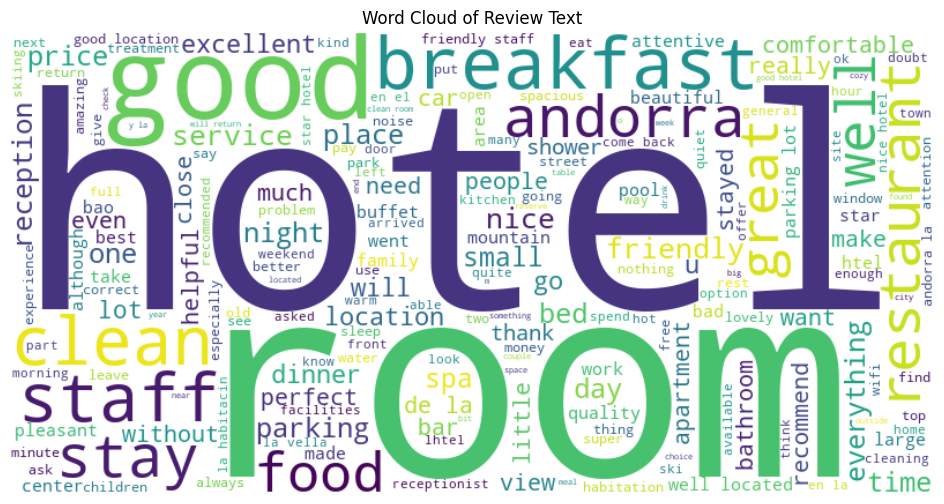

In [24]:
text = ' '.join(df['review_text_translated'].dropna())
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(text)

plt.figure(figsize=(12, 6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud of Review Text')
plt.show()

### 3.2. Language Distribution

Pie chart showing the distribution of review languages.

In [52]:
# Calculate language distribution
language_dist = df['review_language'].value_counts()

# Calculate the threshold for "Others"
total_reviews = language_dist.sum()
threshold = total_reviews * 0.01

# Separate languages above and below the threshold
large_languages = language_dist[language_dist >= threshold]
small_languages = language_dist[language_dist < threshold]

# Combine small languages into "Others"
if small_languages.sum() > 0:
    large_languages['Others'] = small_languages.sum()

# Plot the pie chart with Plotly
fig_pie = px.pie(
    large_languages,
    names=large_languages.index,
    values=large_languages.values,
    title='Distribution of Review Languages',
    color_discrete_sequence=color_palette[8:]
)

fig_pie.update_traces(textposition='inside', textinfo='percent+label')

fig_pie.update_layout(
    title_text='Distribution of Review Languages',
    title_x=0.5,
    width=800,  # Set the width of the plot
    height=600,
    paper_bgcolor='rgba(0,0,0,0)',
    plot_bgcolor='rgba(0,0,0,0)',
    font=dict(
        family="Arial, sans-serif",
        size=12,
        color="#000000"
    )
)

# Show the pie chart
fig_pie.show()

### 3.3. Sentiment Analysis

Bar chart or pie chart showing the distribution of positive, neutral, and negative sentiments in reviews.

In [67]:
# Define a function to classify sentiment
def get_sentiment(text):
    analysis = TextBlob(text)
    if analysis.sentiment.polarity > 0:
        return 'Positive'
    elif analysis.sentiment.polarity == 0:
        return 'Neutral'
    else:
        return 'Negative'

# Apply sentiment analysis
df['sentiment'] = df['review_text'].apply(lambda x: get_sentiment(x) if pd.notnull(x) else 'Neutral')

# Sentiment Distribution
sentiment_dist = df['sentiment'].value_counts()

# Define colors for the sentiment categories
colors = {'Positive': '#2ca02c', 'Neutral': '#1f77b4', 'Negative': '#d62728'}

# Create a bar chart with Plotly
fig_bar = go.Figure()

fig_bar.add_trace(go.Bar(
    x=sentiment_dist.index,
    y=sentiment_dist.values,
    marker_color=[colors[sentiment] for sentiment in sentiment_dist.index],
    name='Sentiment'
))

fig_bar.update_layout(
    title_text='Sentiment Analysis of Reviews',
    title_x=0.5,
    xaxis_title='Sentiment',
    yaxis_title='Frequency',
    plot_bgcolor='rgba(0,0,0,0)',
    paper_bgcolor='rgba(0,0,0,0)',
    font=dict(
        family="Arial, sans-serif",
        size=12,
        color="#000000"
    ),
    xaxis_tickangle=0
)

# Show the bar chart
fig_bar.show()

## 4. Comparison Between Regions

### 4.1. Review Count Comparison

Bar chart comparing the number of reviews between regions.

In [57]:
# Calculate review count per region
review_count_region = df['region'].value_counts()

# Create a bar chart with Plotly
fig_bar = go.Figure()

fig_bar.add_trace(go.Bar(
    x=review_count_region.index,
    y=review_count_region.values,
    marker_color=color_palette[7:],
    name='Review Count'
))

fig_bar.update_layout(
    title_text='Review Count per Region',
    title_x=0.5,
    xaxis_title='Region',
    yaxis_title='Number of Reviews',
    plot_bgcolor='rgba(0,0,0,0)',
    paper_bgcolor='rgba(0,0,0,0)',
    font=dict(
        family="Arial, sans-serif",
        size=16,
        color="#000000"
    ),
    xaxis_tickangle=45
)

# Show the bar chart
fig_bar.show()

### 4.3. Sentiment Comparison

Bar chart comparing sentiment distributions across regions.

In [66]:
# Define a function to classify sentiment
def get_sentiment(text):
    analysis = TextBlob(text)
    if analysis.sentiment.polarity > 0:
        return 'Positive'
    elif analysis.sentiment.polarity == 0:
        return 'Neutral'
    else:
        return 'Negative'

# Apply sentiment analysis
df['sentiment'] = df['review_text'].apply(lambda x: get_sentiment(x) if pd.notnull(x) else 'Neutral')

# Sentiment distribution across regions
sentiment_region = df.groupby(['region', 'sentiment']).size().unstack().fillna(0)

# Create a stacked bar chart with Plotly
fig_bar = go.Figure()

sentiments = ['Positive', 'Neutral', 'Negative']
colors = {'Positive': '#2ca02c', 'Neutral': '#1f77b4', 'Negative': '#d62728'}

for sentiment in sentiments:
    fig_bar.add_trace(go.Bar(
        x=sentiment_region.index,
        y=sentiment_region[sentiment],
        name=sentiment,
        marker_color=colors[sentiment]
    ))

fig_bar.update_layout(
    barmode='stack',
    title_text='Sentiment Comparison across Regions',
    title_x=0.5,
    xaxis_title='Region',
    yaxis_title='Number of Reviews',
    plot_bgcolor='rgba(0,0,0,0)',
    paper_bgcolor='rgba(0,0,0,0)',
    font=dict(
        family="Arial, sans-serif",
        size=16,
        color="#000000"
    ),
    xaxis_tickangle=45,
    legend_title_text='Sentiment'
)

# Show the stacked bar chart
fig_bar.show()

## 5. Business Status Analysis

### 5.1. Business Status Distribution

Pie chart showing the distribution of business status (open, closed, etc.).


In [72]:
# Calculate business status distribution
business_status_dist = df['business_status'].value_counts()

# Plot the pie chart with Plotly
fig_pie = px.pie(
    business_status_dist,
    names=business_status_dist.index,
    values=business_status_dist.values,
    title='Distribution of Business Status',
    color_discrete_sequence=[color_palette[10], color_palette[14]]
)

fig_pie.update_traces(textposition='inside', textinfo='percent+label')

fig_pie.update_layout(
    title_text='Distribution of Business Status',
    title_x=0.5,
    width=800,  # Set the width of the plot
    height=800,  # Set the height of the plot
    paper_bgcolor='rgba(0,0,0,0)',
    plot_bgcolor='rgba(0,0,0,0)',
    font=dict(
        family="Arial, sans-serif",
        size=12,
        color="#000000"
    )
)

# Show the pie chart
fig_pie.show()